In [1]:
# Model calling and intial setup
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
import warnings
warnings.filterwarnings("ignore") 

load_dotenv()
# Load env
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
AZURE_BASE_URL = os.getenv("AZURE_BASE_URL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_CHAT_DEPLIOYMENT_NAME = os.getenv("AZURE_CHAT_DEPLIOYMENT_NAME")

parser = StrOutputParser()

llm_gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash" , api_key= GOOGLE_API_KEY)

llm_openai = AzureChatOpenAI(
    model="gpt-4o-mini",                         
    deployment_name=AZURE_CHAT_DEPLIOYMENT_NAME ,  # deployment name in Azure
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_BASE_URL,
    api_version="2024-02-01"
    )
llm_openai.invoke("What are your creater, also what type of LLM are you").content
# llm_gemini.invoke("who is father of india").content

c:\Users\singh\Let's Gooooo\Langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


"I was developed by OpenAI, an artificial intelligence research organization. I am based on a large language model (LLM) architecture known as GPT (Generative Pre-trained Transformer). My primary function is to understand and generate human-like text based on the input I receive. If you have any specific questions or topics you'd like to discuss, feel free to ask!"

### First conditinal workflow

In [11]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict, Literal

class EqState(TypedDict):
    a : int
    b : int
    c : int
    
    eq : str
    dis : float
    root1 : float
    root2 : float
    
def show_eq(state : EqState)->EqState:
    eq = f"{state['a']}x^2 + {state['b']}x + {state['c']}"
    print(f"Eq : {eq}")
    
    state['eq'] = eq
    return state

def find_discriminate(state:EqState)->EqState:
    dis = (state['b'] **2)- (4 * state['a'] * state['c'])
    
    state['dis'] = dis
    return state

def real_roots(state : EqState)->EqState:
    root1 = (-state['b'] + state["dis"] **0.5) / (2*state['a'])
    root2 = (-state['b'] - state["dis"] **0.5) / (2*state['a'])
    
    state['root1'] = root1
    state['root2'] = root2
    return state

def repeated_roots(state : EqState)->EqState:
    root = (-state['b'])/(2*state['a'])
    
    state['root1'] = root
    state['root2'] = root
    return state

def no_real_roots(state : EqState)->EqState:
    state['root1'] = None
    state['root2'] = None
    return state

def check_condition(state:EqState)->Literal['Get_real_roots' , 'Get_repeated_roots' , 'Get_no_roots']:
    if state['dis'] > 0:
        return 'Get_real_roots'
    
    elif state['dis'] == 0:
        return 'Get_repeated_roots'
    else:
        return 'Get_no_roots'


graph = StateGraph(EqState)

# Add Node
graph.add_node("Show_Equation" , show_eq)
graph.add_node("Get_discriminant" , find_discriminate)
graph.add_node("Get_real_roots" , real_roots)
graph.add_node("Get_repeated_roots" , repeated_roots)
graph.add_node("Get_no_roots" , no_real_roots)

# Add Edges
graph.add_edge(START , "Show_Equation")
graph.add_edge("Show_Equation" , "Get_discriminant")
graph.add_conditional_edges("Get_discriminant" , check_condition)
graph.add_edge("Get_real_roots" , END)
graph.add_edge("Get_repeated_roots" , END)
graph.add_edge("Get_no_roots" , END)

first_workflow = graph.compile()

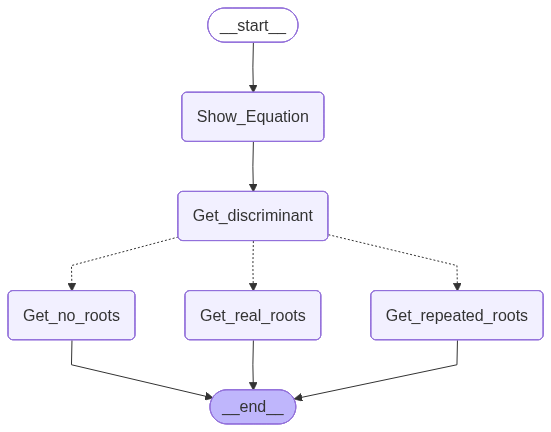

In [12]:
from IPython.display import Image
Image(first_workflow.get_graph().draw_mermaid_png())

In [15]:
first_workflow.invoke({"a" : -1 , "b":-6 , "c" : 8})

Eq : -1x^2 + -6x + 8


{'a': -1,
 'b': -6,
 'c': 8,
 'eq': '-1x^2 + -6x + 8',
 'dis': 68,
 'root1': -7.123105625617661,
 'root2': 1.1231056256176606}

### LLM Based Condtional Workflow

In [24]:
from pydantic import BaseModel , Field
from typing import Literal , TypedDict

class SentimentOutput(BaseModel):
    sentiment : Literal['Postive' , "Negative"] = Field(description="Sentiment of review based, classfiied as positive or negative")
    
class DiagonsisOutput(BaseModel):
    issue_type : str = Field(description="what is type of issue, Explained in breif")
    tone : str = Field(description="Tone of the review, calm , angry and so on etc..")
    urgency : int = Field(description="How Urgent is the urgency of the customer, from 1-10" , ge=0 , le=10)
    
llm_gemini_sentiment = llm_gemini.with_structured_output(SentimentOutput)
llm_gemini_diagonsis = llm_gemini.with_structured_output(DiagonsisOutput)

In [23]:
llm_gemini_diagonsis.invoke("The prodduct is worst that i have seen, and i want my refund right now")

DiagonsisOutput(issue_type='Refund', tone='angry', urgency=10)

In [39]:
# Create a State
from langgraph.graph import StateGraph
from typing import Dict

class CXState(TypedDict):
    review : str
    sentiment : Literal['Postive' , "Negative"] 
    diagonsis : DiagonsisOutput
    responce : str

def find_sentiment(state : CXState)->CXState:
    prompt = PromptTemplate(
        template="You're Customer Care Expert and based on the review of the Customer, you classify the sentiment in either the postive or negative sentiment. Here is the review : \n {review}",
        input_variables=['review']
    )
    
    # Create chain
    sentiment_chain = prompt | llm_gemini_sentiment
    # Invoke chain
    sentiment = sentiment_chain.invoke({"review" : state['review']})
    
    state['sentiment'] = sentiment.sentiment
    return state

def run_diagnosis(state : CXState)->CXState:
    prompt = PromptTemplate(
        template= "You're Customer Care Expert and based on the customer negative review, give me the issue_type, tone of the customer and urgency of this matter. review : \n{review}",
        input_variables=['review']
    )

    diagnosis_chain = prompt | llm_gemini_diagonsis
    diagnosis = diagnosis_chain.invoke({"review" : state['review']})
    state['diagonsis'] = diagnosis
    
    return state

def write_positive_responce(state : CXState)->CXState:
    prompt = PromptTemplate(
        template="You're a Customer Care Executive, baseed on the postive review give by the customer, write a responce replaying and thaking him. make this formal and also try to include detail send by cutomer in his review {review}",
        input_variables=['review']
    )
    
    positive_msg_chain = prompt | llm_openai | parser
    positve_msg = positive_msg_chain.invoke({'review' : state['review']})
    state['responce'] = positve_msg
    
    return state

def write_negative_responce(state : CXState)->CXState:
    prompt = PromptTemplate(
        template="You're a Customer Care Executive, baseed on the negative review give by the customer, write a responce replaying and geratting it. make this formal and also try to include detail send by cutomer in his review {review} , here the more details about the review.\n1)issue_type : {issue_type}\n2)tone of customer : {tone}\n3)urgency on the Scale of 1-10 : {urgency}",
        input_variables=['review' , 'issue_type' , 'tone' , 'urgency']
    )
    
    negative_msg_chain = prompt | llm_openai | parser
    negative_msg = negative_msg_chain.invoke({'review' : state['review'] ,'issue_type' : state['diagonsis'].issue_type, "tone" : state['diagonsis'].tone , 'urgency' : state['diagonsis'].urgency})
    state['responce'] = negative_msg
    
    return state


def responce_classification(state:CXState) -> Literal[ 'Run_Diagnosis', 'Positive_Responce']:
    if state['sentiment'] == "Negative":
        return "Run_Diagnosis"
    elif state['sentiment'] == "Postive":
        return "Positive_Responce"
       
graph = StateGraph(CXState)

# Add Node
graph.add_node("Get_Sentiment" , find_sentiment)
graph.add_node("Run_Diagnosis" , run_diagnosis)
graph.add_node("Positive_Responce" , write_positive_responce)
graph.add_node("Negative_Responce" , write_negative_responce)

# Add Edges
graph.add_edge(START , "Get_Sentiment")
graph.add_conditional_edges("Get_Sentiment" , responce_classification)

graph.add_edge("Run_Diagnosis" , "Negative_Responce")
graph.add_edge("Negative_Responce" , END)

graph.add_edge("Positive_Responce" , END)

cx_workflow = graph.compile()


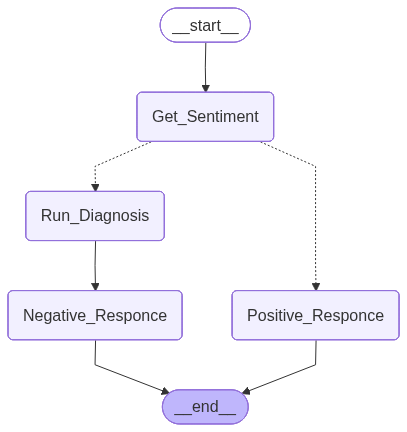

In [40]:
from IPython.display import Image
Image(cx_workflow.get_graph().draw_mermaid_png())

In [46]:
input_state = {"review" : "I purchased the Galaxy A36 hoping for a reliable and affordable phone, but it hasn't lived up to my expectations. While the display is nice and bright, the performance is a huge letdown. Scrolling and typing feel laggy, especially compared to my older phone."}
output_state = cx_workflow.invoke(input_state)
output_state

{'review': "I purchased the Galaxy A36 hoping for a reliable and affordable phone, but it hasn't lived up to my expectations. While the display is nice and bright, the performance is a huge letdown. Scrolling and typing feel laggy, especially compared to my older phone.",
 'sentiment': 'Negative',
 'diagonsis': DiagonsisOutput(issue_type='Performance issues with laggy scrolling and typing', tone='disappointed', urgency=7),
 'responce': 'Subject: Response to Your Feedback on the Galaxy A36\n\nDear Valued Customer,\n\nThank you for taking the time to share your experience with the Galaxy A36. We sincerely appreciate your feedback, as it helps us improve our products and services.\n\nWe are truly sorry to hear that your experience with the Galaxy A36 has not met your expectations, particularly regarding the performance issues you mentioned. While we are glad to know that you appreciate the bright and vibrant display, it’s disheartening to learn about the laggy scrolling and typing that yo

In [47]:
print(output_state.get("responce"))

Subject: Response to Your Feedback on the Galaxy A36

Dear Valued Customer,

Thank you for taking the time to share your experience with the Galaxy A36. We sincerely appreciate your feedback, as it helps us improve our products and services.

We are truly sorry to hear that your experience with the Galaxy A36 has not met your expectations, particularly regarding the performance issues you mentioned. While we are glad to know that you appreciate the bright and vibrant display, it’s disheartening to learn about the laggy scrolling and typing that you have been experiencing. We understand how frustrating it can be when a device does not deliver the reliable performance it promises.

Your concerns regarding performance are important to us, and we would like to investigate this matter further to assist you appropriately. Please let us know if there are any specific applications or scenarios where the lag is particularly noticeable, as this information could be helpful in troubleshooting the